In [ ]:
import os
import sys

# Move the working directory and change directory to the parent folder
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
os.chdir(parent_dir)

In [ ]:
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, TypedDict, Union

from langchain_core.messages import AnyMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.types import Command
from src.logger_initialization import initialize_logger
from typing_extensions import Annotated, Literal

In [ ]:
from src.agents import (
    full_information_grader_agent,
    question_rewriter_agent,
    rag_chain_agent,
)
from src.parsing_utils import (
    add_credibility_web_search,
    create_retriever_in_memory,
    exa_search_results,
    retrieve_with_credibility,
)

2025-12-29 07:23:20 - parsing_utils_logger - INFO - Logger 'parsing_utils_logger' initialized with log file: logs\parsing_utils_2025-12-29.log


In [4]:
logger = initialize_logger("main_graph")

2025-12-29 07:23:25 - main_graph_logger - INFO - Logger 'main_graph_logger' initialized with log file: logs\main_graph_2025-12-29.log


In [5]:
MAX_RETRIES = 1

## Creating graph

In [6]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
        retry_count: retry count initialized to 0
    """

    messages_list: Annotated[list[AnyMessage], add_messages]
    company_name: str = ""
    question: str = ""

    generation: str = ""
    follow_up_question: str = ""
    documents: List[str] = field(default_factory=list)
    retry_count: int = 0
    test_count: int = 0
    parameters: List[str] = field(default_factory=list)
    web_results: List[str] = field(default_factory=list)

In [7]:
async def retries_increment_node(
    state, config: RunnableConfig
) -> Command[Literal["question_rewriter_node", END]]:
    thread_id = config["configurable"]["thread_id"]

    retry_count = state.get("retry_count", 0)
    incremented_retry_count = retry_count + 1

    logger.info(
        f"Thread: {thread_id} - Retry count increment {incremented_retry_count}"
    )
    logger.info(f"---RETRY COUNT INCREMENT {incremented_retry_count}---")

    if incremented_retry_count >= MAX_RETRIES:
        logger.info(f"Thread: {thread_id} - Reached maximum number of retries, stop")
        return Command(
            # state update
            update={"retry_count": incremented_retry_count},
            # control flow
            goto=END,
        )
    else:
        logger.info(f"Thread: {thread_id} - Proceed to web search")
        return Command(
            # state update
            update={"retry_count": incremented_retry_count},
            # control flow
            goto="question_rewriter_node",
        )

In [8]:
async def full_answer_check_node(
    state, config: RunnableConfig
) -> Command[Literal[END, "retries_increment_node"]]:
    thread_id = config["configurable"]["thread_id"]
    logger.info(f"Thread: {thread_id} - Full answer check")
    question = state["question"]
    generation = state["generation"]

    # Invoke the grading function
    input_prompt = f"User question: \n\n {question} \n\n LLM generation: {generation}"
    result = await full_information_grader_agent.run(input_prompt)
    binary_score = result.output.binary_score
    logger.info(f"Thread: {thread_id} - Full answer check result: {binary_score}")
    if binary_score:
        return Command(goto=END)

    else:
        logger.info(
            f"Thread: {thread_id} - New question: {result.output.follow_up_question}"
        )

        return Command(
            # state update
            update={"follow_up_question": result.output.follow_up_question},
            goto="retries_increment_node",
        )

In [9]:
async def generate_answer_node(state, config: RunnableConfig):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    thread_id = config["configurable"]["thread_id"]
    logger.info(f"Thread: {thread_id} - Generate")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    input_prompt = f"Question: {question}\nDocuments: {documents}"
    result = await rag_chain_agent.run(input_prompt)
    generation = result.output
    logger.info(f"Thread: {thread_id} - Generation: {generation}")
    return {"generation": generation}

In [10]:
async def question_rewriter_node(state, config: RunnableConfig):
    thread_id = config["configurable"]["thread_id"]
    logger.info(f"Thread: {thread_id} - Generate")
    question = state["question"]
    follow_up_question = state["follow_up_question"]
    documents = state["documents"]

    # RAG generation
    input_prompt = f"Question: {question} \nFollow-up question: {follow_up_question} \nDocument: {documents[:1]}"
    result = await question_rewriter_agent.run(input_prompt)
    new_question = result.output.updated_query
    logger.info(f"Thread: {thread_id} - New question: {new_question}")
    return {"question": new_question}

In [11]:
async def web_search_node(state, config: RunnableConfig):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    thread_id = config["configurable"]["thread_id"]
    logger.info(f"Thread: {thread_id} - Web search")
    question = state["question"]
    # Web search

    web_results = await exa_search_results(question)
    logger.info(f"Thread: {thread_id} - Exa search done")
    web_results = await add_credibility_web_search(web_results, question)
    logger.info(f"Thread: {thread_id} - Credibility done")

    if web_results:
        logger.info(f"Thread: {thread_id} - Creating retriever in memory...")
        vector_store = create_retriever_in_memory(web_results)

        if vector_store is not None:
            logger.info(
                f"Thread: {thread_id} - Retrieving documents from the vectorstore..."
            )
            documents_web = retrieve_with_credibility(vector_store, question)

        else:
            documents_web = []

    else:
        documents_web = []

    return {"documents": documents_web, "web_results": web_results}

In [12]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search_node", web_search_node)  # Web search if needed

workflow.add_node("generate_answer_node", generate_answer_node)  # Generate response
workflow.add_node("retries_increment_node", retries_increment_node)
workflow.add_node("full_answer_check_node", full_answer_check_node)
workflow.add_node("question_rewriter_node", question_rewriter_node)


workflow.add_edge(START, "web_search_node")

workflow.add_edge("web_search_node", "generate_answer_node")
workflow.add_edge("generate_answer_node", "full_answer_check_node")

workflow.add_edge("question_rewriter_node", "web_search_node")

In [13]:
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()

# Compile
websearch_graph = workflow.compile(checkpointer=checkpointer)

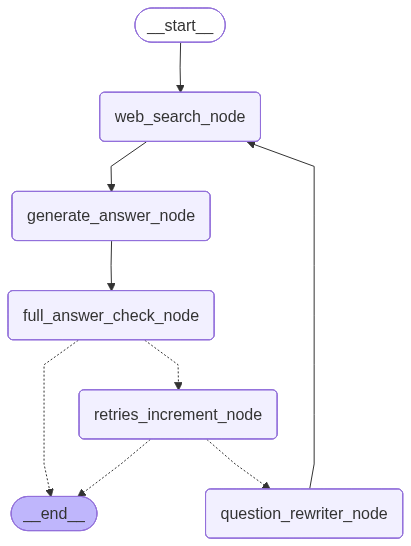

In [14]:
from IPython.display import Image, display

try:
    display(Image(websearch_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
thread = {"configurable": {"thread_id": "1"}, "run_name": "test_run"}

example_input = {"question": "What is ebitda of euNetworks?"}

In [16]:
result = await websearch_graph.ainvoke(input=example_input, config=thread)

2025-12-29 07:23:54 - main_graph_logger - INFO - Thread: 1 - Web search
2025-12-29 07:23:54 - parsing_utils_logger - INFO - Start exa search with query: What is ebitda of euNetworks?
2025-12-29 07:24:01 - parsing_utils_logger - INFO - Exa search completed with 15 results
2025-12-29 07:24:01 - parsing_utils_logger - INFO - Found 15 new documents: ['https://live.euronext.com/en/products/equities/company-news/2023-04-17-2022-annual-results-revenue-and-ebitda-above-targets', 'https://eunetworks.com/app/uploads/2023/06/euNetworks-Holdings-Limited-FS-31.12.2022-vFF.pdf', 'https://eunetworks.com/app/uploads/2024/06/ESO.04.04-Ax3-euNetworks-Holdings-LP-FS-31.12.2023-v4.pdf', 'https://eunetworks.com/app/uploads/2022/06/euNetworks-Holdings-LP-FS-31.12.21-.pdf', 'https://www.lightreading.com/cable-technology/eunetworks-posts-8364-18-5m-loss-in-h1', 'https://eunetworks.com/investor-relations/', 'https://www.cbinsights.com/company/eunetworks', 'https://tracxn.com/d/companies/eunetworks/__3JwJwA53TB

Processing documents: 100%|██████████| 15/15 [00:00<00:00, 33288.13it/s]

2025-12-29 07:24:06 - parsing_utils_logger - INFO - Processed 15 documents
2025-12-29 07:24:06 - main_graph_logger - INFO - Thread: 1 - Exa search done
2025-12-29 07:24:06 - parsing_utils_logger - INFO - ---ADD CREDIBILITY TO DOCUMENTS---
2025-12-29 07:24:06 - parsing_utils_logger - INFO - Adding credibility to web document -- https://live.euronext.com/en/products/equities/company-news/2023-04-17-2022-annual-results-revenue-and-ebitda-above-targets
2025-12-29 07:24:06 - parsing_utils_logger - INFO - Adding credibility to web document -- https://eunetworks.com/app/uploads/2023/06/euNetworks-Holdings-Limited-FS-31.12.2022-vFF.pdf
2025-12-29 07:24:06 - parsing_utils_logger - INFO - Adding credibility to web document -- https://eunetworks.com/app/uploads/2024/06/ESO.04.04-Ax3-euNetworks-Holdings-LP-FS-31.12.2023-v4.pdf
2025-12-29 07:24:06 - parsing_utils_logger - INFO - Adding credibility to web document -- https://eunetworks.com/app/uploads/2022/06/euNetworks-Holdings-LP-FS-31.12.21-.pdf


2025-12-29 07:24:10 - main_graph_logger - INFO - Thread: 1 - Credibility done
2025-12-29 07:24:10 - main_graph_logger - INFO - Thread: 1 - Creating retriever in memory...
2025-12-29 07:24:13 - parsing_utils_logger - INFO - Adding documents to the inmemory vectorstore
2025-12-29 07:24:18 - parsing_utils_logger - INFO - Documents added to the inmemory vectorstore
2025-12-29 07:24:18 - main_graph_logger - INFO - Thread: 1 - Retrieving documents from the vectorstore...
2025-12-29 07:24:19 - main_graph_logger - INFO - Thread: 1 - Generate
2025-12-29 07:24:52 - main_graph_logger - INFO - Thread: 1 - Generation: - euNetworks reports “Adjusted EBITDA” (defined as earnings before interest, tax, depreciation, amortisation, profit/loss on disposal of plant and equipment, and long-term incentive plan costs). For the year ended 31 December 2021, Adjusted EBITDA was €119.8 million (2020: €111.9 million; 2019: €94.5 million) (According to euNetworks Holdings LP (Reg: 93017, Cayman Islands) Report and